# Explore here

In [135]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import json 

In [136]:
data = pd.read_csv("../data/raw/medical_insurance_cost.csv", sep = ",")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [138]:
columns_with_nan = data.columns[data.isna().any()].tolist()
print(f"Hay {len(columns_with_nan)} columnas con valores nulos")

### Valorar ###
# if len(columns_with_nan) > 0:
#     data.fillna(data.mean())

Hay 0 columnas con valores nulos


In [139]:
target = ["charges"]
categoric_var = [c for c in list(data.dtypes[data.dtypes == "object"].index)]
numeric_var = [c for c in list(data.dtypes[data.dtypes != "object"].index)]

In [140]:
data.shape

(1338, 7)

In [141]:
duplicados = data[data.duplicated()]
data = data.drop_duplicates().reset_index(drop = True)
 
print(f"Medidas del dataset despues de duplicar filas iguales: {data.shape}")
print("Fila duplicada:")
print(duplicados)

Medidas del dataset despues de duplicar filas iguales: (1337, 7)
Fila duplicada:
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


NUMERICAL ANALYSIS

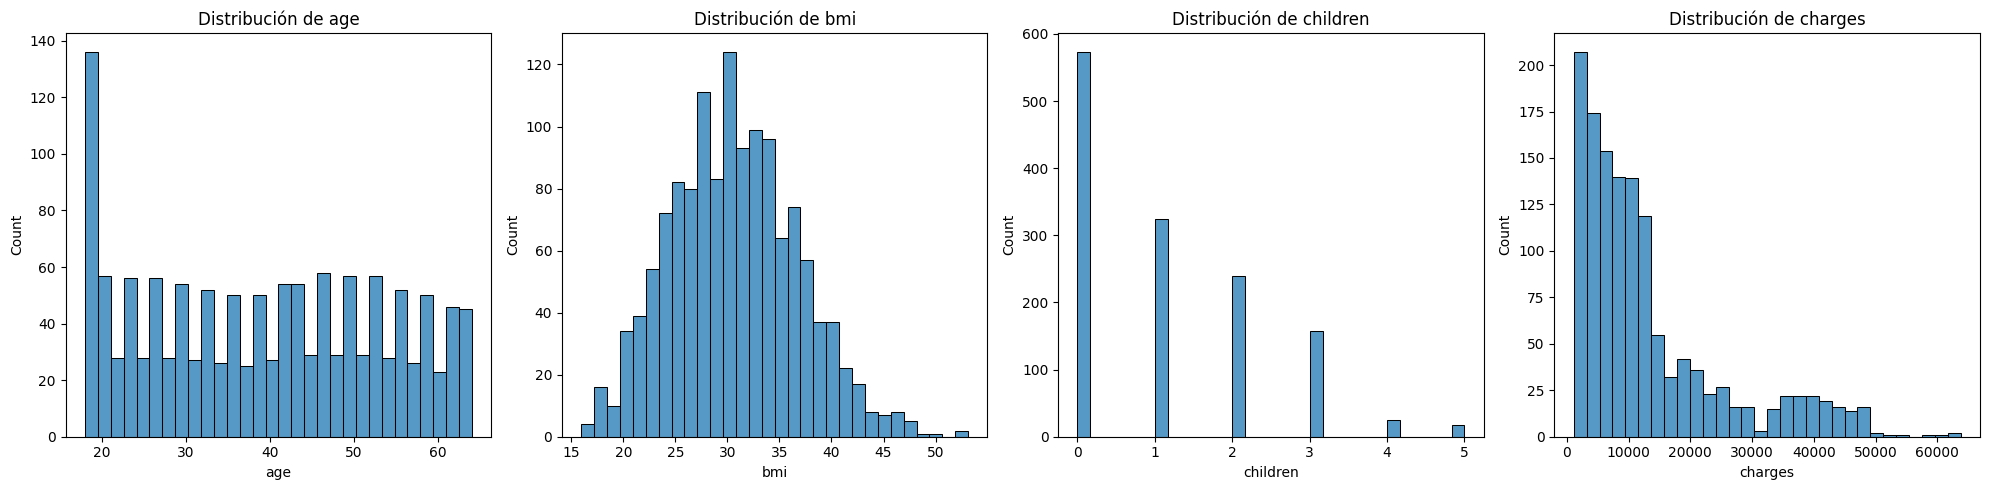

In [142]:
def graficar_distribucion_numerica(df, columns):
    
    n = len(columns)
    n_columns = 4  
    n_rows = (n // n_columns) + (n % n_columns > 0)  
    
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns * 5, n_rows * 5))
    
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.histplot(df[col], bins=30, ax=axes[i])
        axes[i].set_title(f'Distribución de {col}')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')  
    
    plt.tight_layout()
    plt.show()

graficar_distribucion_numerica(data, numeric_var)

-
-
-

CATEGORICAL ANALYSIS 

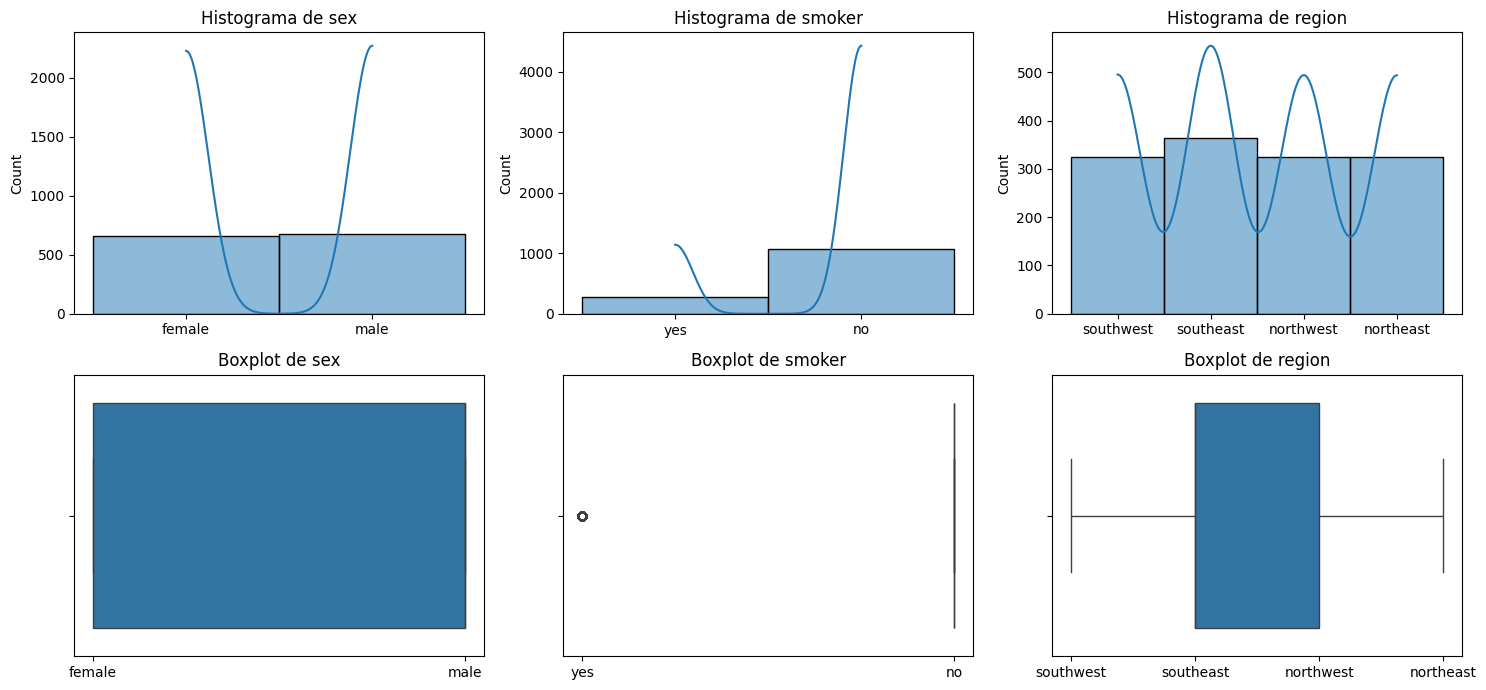

In [143]:
def graficar_categoricas(df, columnas):
   
    n = len(columnas)  
    n_columnas = 3 
    n_filas = 2
    
    fig, axis = plt.subplots(n_filas, n_columnas, figsize=(15, 7))
    
    axis = axis.flatten()

    for i, col in enumerate(columnas):
        sns.histplot(df[col], bins=30, kde=True, ax=axis[i]).set(xlabel=None)
        axis[i].set_title(f'Histograma de {col}')
                
        sns.boxplot(data=df, x=col, ax=axis[i + n_columnas]).set(xlabel=None)
        axis[i + n_columnas].set_title(f'Boxplot de {col}')
    
    plt.tight_layout()
    plt.show()

### Segmentar por "n_columns" para que salgan los hisplots/boxplots.
graficar_categoricas(data, categoric_var)


-
-
-

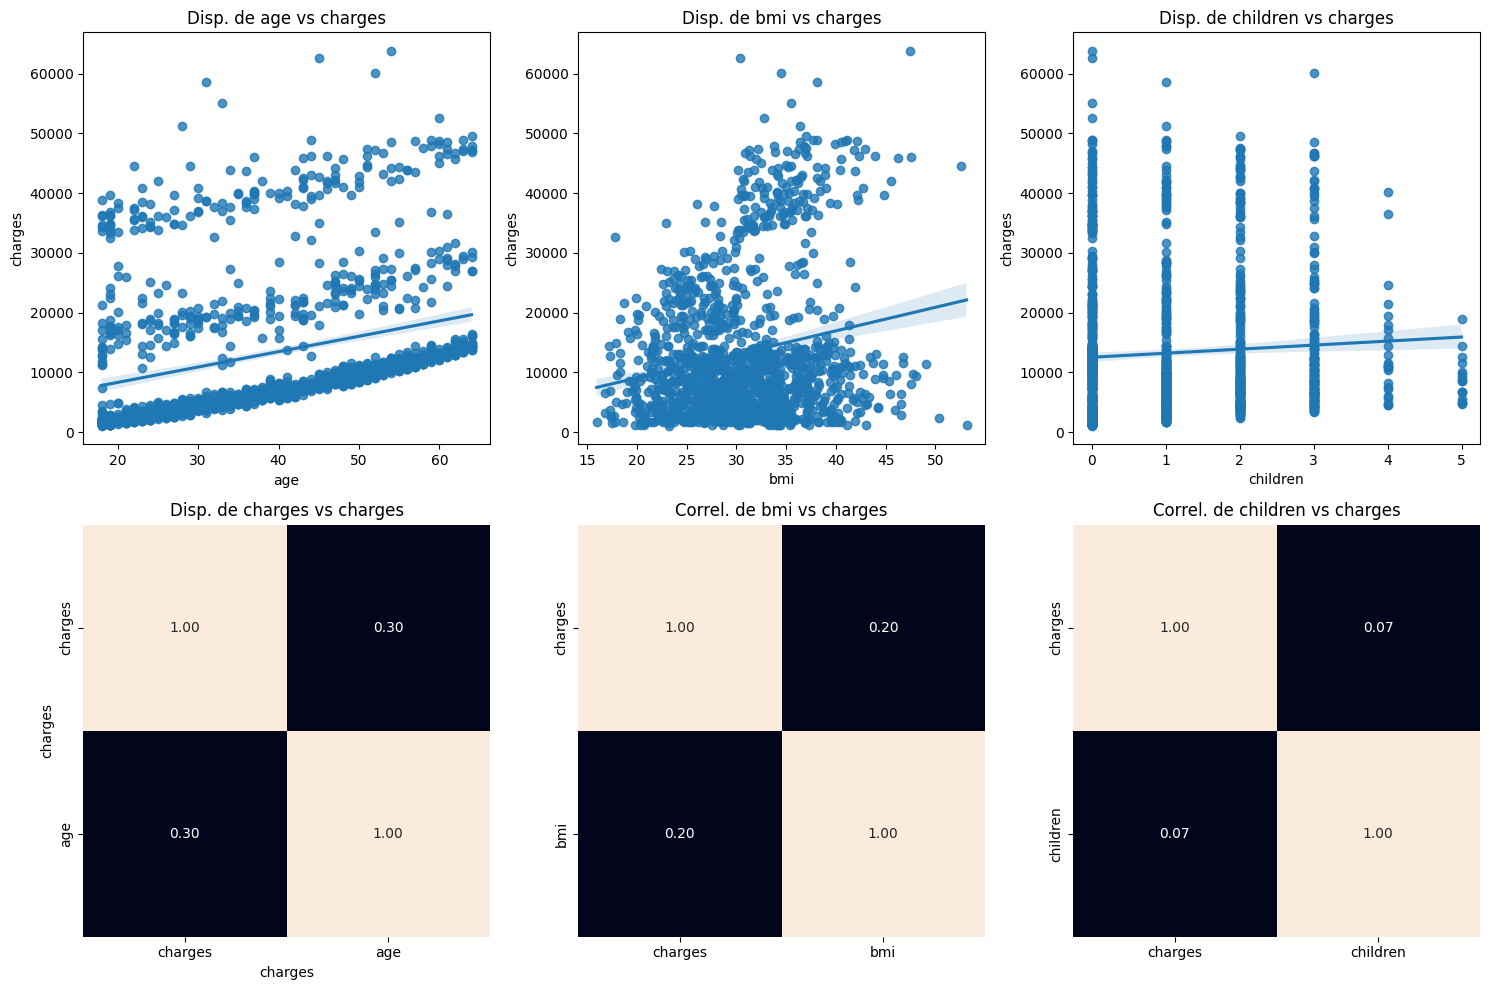

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_dispersiones_y_heatmaps(df, columnas, target_col):
    n = len(columnas)  
    n_columnas = 3  
    n_filas = (n // n_columnas) + 1  # Calcular cuántas filas son necesarias según el número de columnas
    
    fig, axis = plt.subplots(n_filas, n_columnas, figsize=(15, 10))
    
    # Aplanar el arreglo de ejes para que sea más fácil acceder a él
    axis = axis.flatten()
    
    # Iterar a través de las columnas para crear los gráficos
    for i, col in enumerate(columnas):
        if i < len(axis):  # Asegurarse de no exceder el número de subgráficas
            sns.regplot(ax=axis[i], data=df, x=col, y=target_col)
            axis[i].set_title(f'Disp. de {col} vs {target_col}')
        
            # Aquí ajustamos para evitar un índice fuera de rango
            if i + n_columnas < len(axis):
                sns.heatmap(df[[target_col, col]].corr(), annot=True, fmt=".2f", ax=axis[i + n_columnas], cbar=False)
                axis[i + n_columnas].set_title(f'Correl. de {col} vs {target_col}')
    
    plt.tight_layout()
    plt.show()

# Llamar a la función con tus datos y variables
graficar_dispersiones_y_heatmaps(data, numeric_var, "charges")


-
-
-

FACTORIZAR VARIABLES CATEGÓRICAS 

In [145]:
data["sex"] = pd.factorize(data["sex"])[0]
data["smoker"] = pd.factorize(data["smoker"])[0]
data["region"] = pd.factorize(data["region"])[0]

ANÁLISIS CORRELACIONES

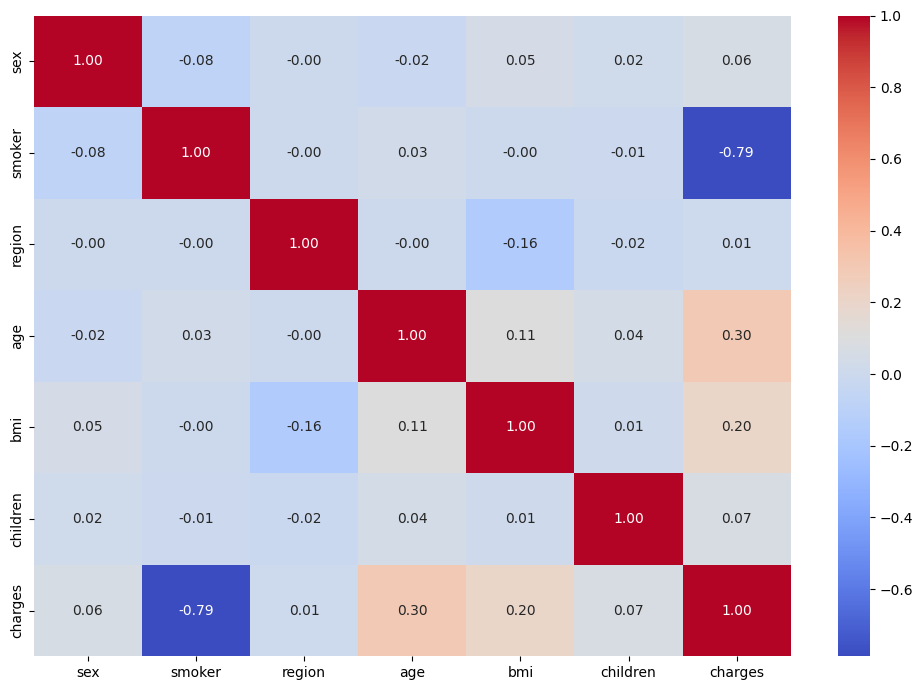

In [146]:
fig, axis = plt.subplots(figsize = (10, 7))

sns.heatmap(data[categoric_var + numeric_var].corr(), annot = True, fmt = ".2f", cmap = "coolwarm")

plt.tight_layout()

plt.show()

- No se aprecian relaciones fuertes. 

ANÁLISIS OUTLIERS

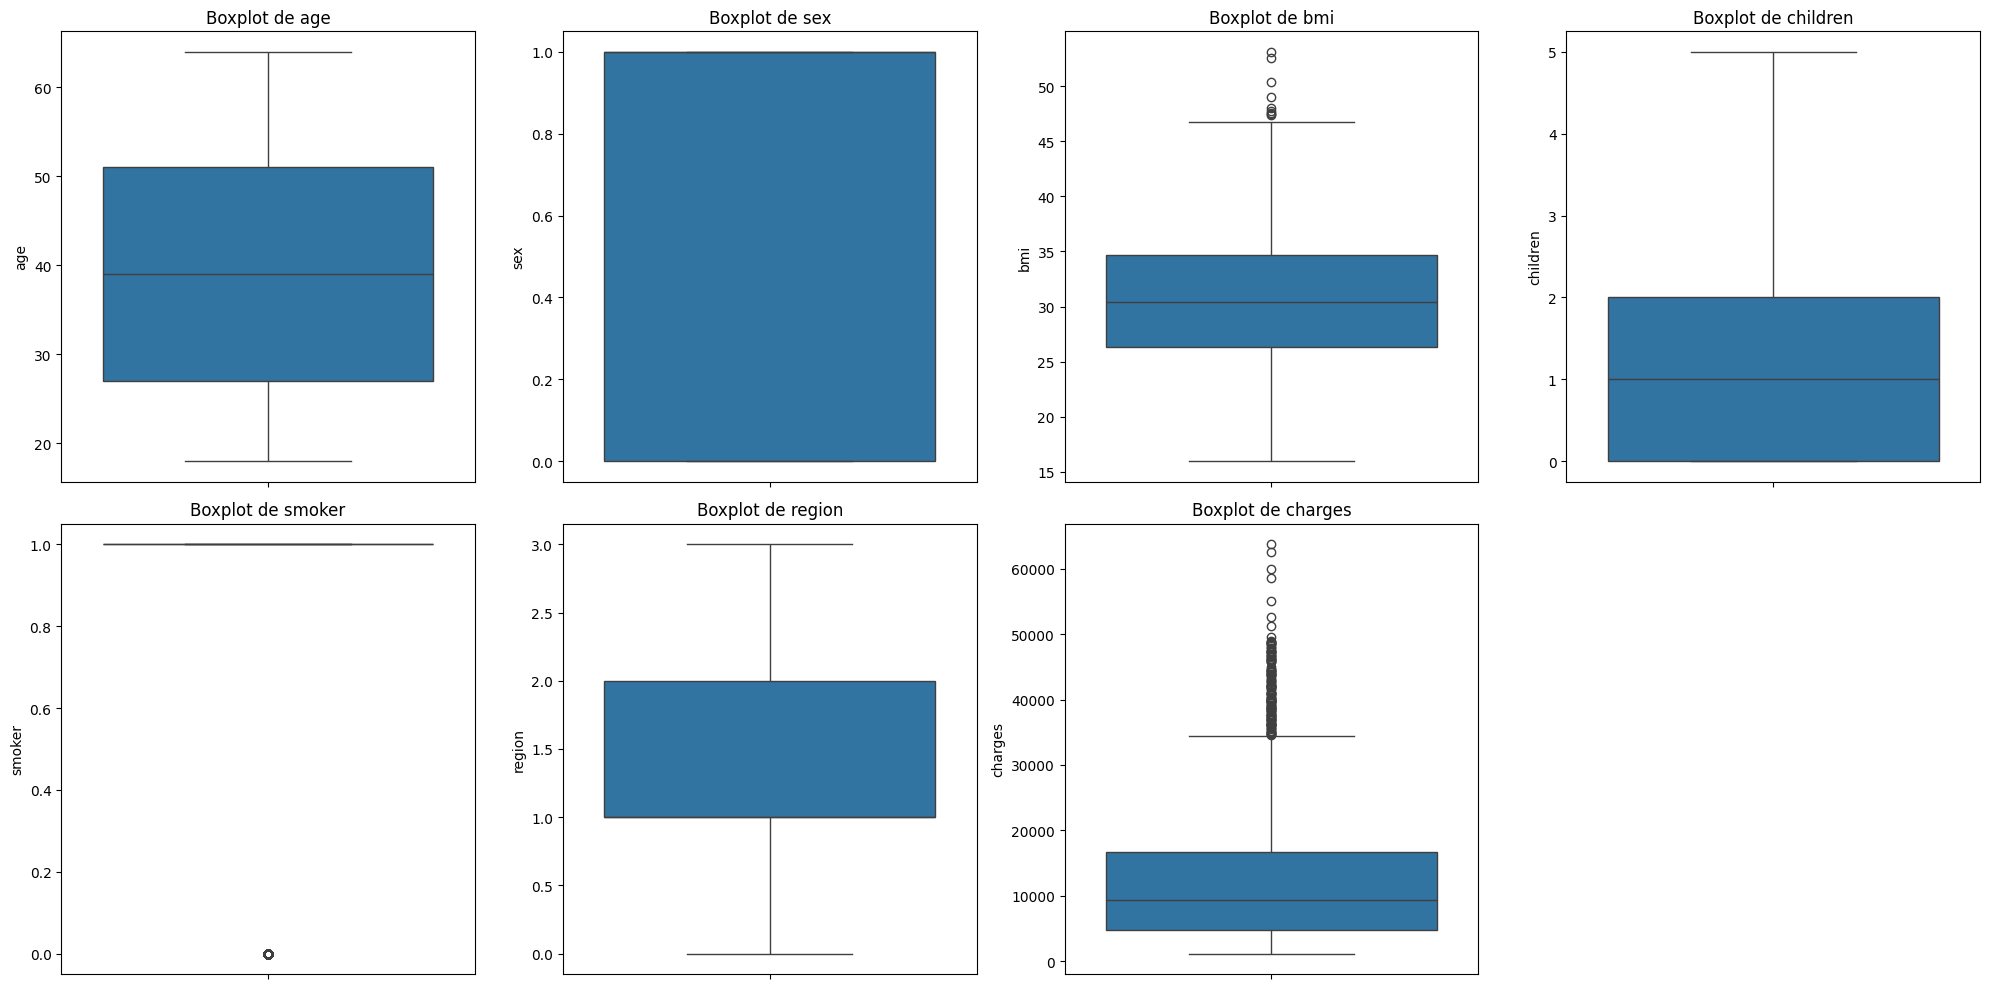

In [147]:
def generar_boxplots_automaticos(df):
   
    # Filtrar las columnas numéricas del DataFrame, como ya esta normalizado, son todas. 
    columnas = df.columns

    n_columnas = 4
    n_filas = (len(columnas) + n_columnas - 1) // n_columnas  # Redondeo hacia arriba

    # Crear la figura y los ejes para los subgráficos
    fig, axis = plt.subplots(n_filas, n_columnas, figsize=(n_columnas * 5, n_filas * 5))

    # Aplanar el array de ejes para facilitar la iteración
    axis = axis.flatten()

    # Graficar un boxplot para cada columna del DataFrame
    for i, col in enumerate(columnas):
        sns.boxplot(ax=axis[i], data=df, y=col)
        axis[i].set_title(f'Boxplot de {col}')

    # Si hay menos gráficos que subgráficos, ocultar los ejes restantes
    for j in range(i + 1, len(axis)):
        axis[j].axis('off')

    # Ajustar el layout para evitar que los gráficos se sobrepongan
    plt.tight_layout()
    plt.show()

generar_boxplots_automaticos(data)

REEMPLAZAR OUTLIERS 

In [148]:
data_sin_outliers = data.copy()

col_con_outliers = ["bmi"] # añadir outliers

def replace_outliers_from_column(column, df):
  column_stats = df[column].describe()
  column_iqr = column_stats["75%"] - column_stats["25%"]
  upper_limit = column_stats["75%"] + 1.5 * column_iqr
  lower_limit = column_stats["25%"] - 1.5 * column_iqr
  if lower_limit < 0: lower_limit = min(df[column])
  # Remove upper outliers
  df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Remove lower outliers
  df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in col_con_outliers:
  total_data_sin_outliers, limits_list = replace_outliers_from_column(column, data_sin_outliers)
  outliers_dict[column] = limits_list

with open("../models/outliers_replacement.json", "w") as f:
  json.dump(outliers_dict, f)

outliers_dict

{'bmi': [np.float64(13.674999999999994), np.float64(47.31500000000001)]}

SPLIT 

In [149]:
from sklearn.model_selection import train_test_split

# Separar características (X) y la variable objetivo (target)
X = data.drop(target, axis=1)  # Aquí 'target' es el nombre de la columna objetivo
y = data[target]

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
num_variables = data.copy().drop(target, axis= 1).columns.tolist()

# Dividimos el conjunto de datos en muestras de train y test
X_con_outliers = data.drop(target, axis = 1)[num_variables]
X_sin_outliers = total_data_sin_outliers.drop(target, axis = 1)[num_variables]
y = data[target]

X_train_con_outliers, X_test_con_outliers, y_train, y_test = train_test_split(X_con_outliers, y, test_size = 0.2, random_state = 42)
X_train_sin_outliers, X_test_sin_outliers = train_test_split(X_sin_outliers, test_size = 0.2, random_state = 42)

# GUARDAR LOS DATASETS
X_train_con_outliers.to_csv("../data/processed/X_train_con_outliers.csv", index = False)
X_train_sin_outliers.to_csv("../data/processed/X_train_sin_outliers.csv", index = False)
X_test_con_outliers.to_csv("../data/processed/X_test_con_outliers.csv", index = False)
X_test_sin_outliers.to_csv("../data/processed/X_test_sin_outliers.csv", index = False)
y_train.to_csv("../data/processed/y_train.csv", index = False)
y_test.to_csv("../data/processed/y_test.csv", index = False)

ESCALADO

In [150]:
from sklearn.preprocessing import StandardScaler
import pickle

### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
normalizador_con_outliers = StandardScaler()
normalizador_con_outliers.fit(X_train_con_outliers)

with open("../models/normalizador_con_outliers.pkl", "wb") as file:
  pickle.dump(normalizador_con_outliers, file)

X_train_con_outliers_norm = normalizador_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_norm = pd.DataFrame(X_train_con_outliers_norm, index = X_train_con_outliers.index, columns = num_variables)

X_test_con_outliers_norm = normalizador_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_norm = pd.DataFrame(X_test_con_outliers_norm, index = X_test_con_outliers.index, columns = num_variables)

# GUARDAR LOS DATASETS
X_train_con_outliers_norm.to_csv("../data/processed/X_train_con_outliers_norm.csv", index = False)
X_test_con_outliers_norm.to_csv("../data/processed/X_test_con_outliers_norm.csv", index = False)

### NORMALIZAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
normalizador_sin_outliers = StandardScaler()
normalizador_sin_outliers.fit(X_train_sin_outliers)

with open("../models/normalizador_sin_outliers.pkl", "wb") as file:
  pickle.dump(normalizador_sin_outliers, file)

X_train_sin_outliers_norm = normalizador_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_norm = pd.DataFrame(X_train_sin_outliers_norm, index = X_train_sin_outliers.index, columns = num_variables)

X_test_sin_outliers_norm = normalizador_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_norm = pd.DataFrame(X_test_sin_outliers_norm, index = X_test_sin_outliers.index, columns = num_variables)

# GUARDAR LOS DATASETS
X_train_sin_outliers_norm.to_csv("../data/processed/X_train_sin_outliers_norm.csv", index = False)
X_test_sin_outliers_norm.to_csv("../data/processed/X_test_sin_outliers_norm.csv", index = False)

X_train_con_outliers_norm.head()

,age,sex,bmi,children,smoker,region
1113,-1.157680,0.971409,-0.996928,-0.907908,0.500292,1.383946
967,-1.300619,0.971409,-0.792762,0.766904,0.500292,1.383946
598,0.914926,-1.029432,1.154664,0.766904,0.500292,0.477983
170,1.701087,0.971409,1.806837,-0.907908,0.500292,-0.427981
275,0.557580,-1.029432,-0.651417,0.766904,0.500292,1.383946


NORMALIZADO

In [151]:
from sklearn.preprocessing import MinMaxScaler

### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
scaler_con_outliers = MinMaxScaler()
scaler_con_outliers.fit(X_train_con_outliers)

with open("../models/scaler_con_outliers.pkl", "wb") as file:
  pickle.dump(scaler_con_outliers, file)

X_train_con_outliers_scal = scaler_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_scal = pd.DataFrame(X_train_con_outliers_scal, index = X_train_con_outliers.index, columns = num_variables)

X_test_con_outliers_scal = scaler_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_scal = pd.DataFrame(X_test_con_outliers_scal, index = X_test_con_outliers.index, columns = num_variables)

# GUARDAR LOS DATASETS
X_train_con_outliers_scal.to_csv("../data/processed/X_train_con_outliers_scal.csv", index = False)
X_test_con_outliers_scal.to_csv("../data/processed/X_test_con_outliers_scal.csv", index = False)

### ESCALAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
scaler_sin_outliers = MinMaxScaler()
scaler_sin_outliers.fit(X_train_sin_outliers)

with open("../models/scaler_sin_outliers.pkl", "wb") as file:
  pickle.dump(scaler_sin_outliers, file)

X_train_sin_outliers_scal = scaler_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_scal = pd.DataFrame(X_train_sin_outliers_scal, index = X_train_sin_outliers.index, columns = num_variables)

X_test_sin_outliers_scal = scaler_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_scal = pd.DataFrame(X_test_sin_outliers_scal, index = X_test_sin_outliers.index, columns = num_variables)

# GUARDAR LOS DATASETS
X_train_sin_outliers_scal.to_csv("../data/processed/X_train_sin_outliers_scal.csv", index = False)
X_test_sin_outliers_scal.to_csv("../data/processed/X_test_sin_outliers_scal.csv", index = False)

X_train_con_outliers_scal.head()

,age,sex,bmi,children,smoker,region
1113,0.108696,1.0,0.230024,0.0,1.0,1.000000
967,0.065217,1.0,0.263250,0.4,1.0,1.000000
598,0.739130,0.0,0.580172,0.4,1.0,0.666667
170,0.978261,1.0,0.686306,0.0,1.0,0.333333
275,0.630435,0.0,0.286252,0.4,1.0,1.000000
